## libraries

In [1]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
import contextily as cx
import re
from shapely.geometry import Point
from multiprocessing import Pool, cpu_count
import time
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3
matplotlib version: 3.9.2
flopy version: 3.9.2


## define simulation

In [2]:
# simulation setup
sim_name = 'rgtihm'
workspace = './model'
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=workspace,
    exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim,
                           modelname=sim_name)
print("simulation and gwf packages created.")

simulation and gwf packages created.


## tdis

In [3]:
# tdis (temporal discretization) parameters
nper = 898
start_date = datetime(1940, 3, 1)
perioddata = []
for i in range(nper):
    month_start = start_date + timedelta(days=sum(p[0] for p in perioddata))
    if month_start.month == 12:
        month_end = datetime(month_start.year + 1, 1, 1)
    else:
        month_end = datetime(month_start.year, month_start.month + 1, 1)
    perlen = (month_end - month_start).days
    nstp = 2
    tsmult = 1.0
    perioddata.append((float(perlen), nstp, tsmult))

# create tdis
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units='days',
    nper=nper,
    perioddata=perioddata,
    start_date_time=start_date.strftime('%Y-%m-%d'),
)
print("tdis package created.")

tdis package created.


## dis

In [8]:
# tried feet units with meter crs, failed due to misalignment; tried rotation from lower-left, shifted grid left
# tried fixing top-left rotation, still misaligned; adopted anchoring rotation at top-left, matching qgis points
# may be use exact qgis corners for precision, ensure grid aligns with real-world data via rasterio

# model crs for spatial reference
model_crs = 'epsg:26913'
xul = 251539.8073999998  # top-left x in meters, matches qgis
yul = 3639665.581800001  # top-left y in meters, matches qgis
angrot = 24.0  # rotation in degrees, matches qgis

# grid setup, all in meters
nlay = 9  # number of layers
nrow = 912  # number of rows
ncol = 328  # number of columns
delr = np.full(ncol, 660.0 * 0.3048)  # cell width in meters (660 ft to m)
delc = np.full(nrow, 660.0 * 0.3048)  # cell height in meters (660 ft to m)
# elevation data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'
bot_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

# load top elevation, convert feet to meters
try:
    top = np.loadtxt(top_file, dtype=float)
    if top.shape != (nrow, ncol):
        print(f"warning: top shape mismatch {top.shape}")
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
    top = np.where(top == -99999, np.nan, top * 0.3048)  # ft to m
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    import sys
    sys.exit(1)

# load bottom elevations, convert feet to meters
botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: bot shape mismatch {data.shape}")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = np.where(data == -99999, np.nan, data * 0.3048)  # ft to m
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        import sys
        sys.exit(1)

# load active area shapefile
shp_path = './shps/active_area.shp'
try:
    gdf = gpd.read_file(shp_path)
    if gdf.crs != model_crs:
        print(f"reprojecting shapefile crs")
        gdf = gdf.to_crs(model_crs)
    if len(gdf) != 1:
        print(f"warning: multiple features, using first")
    geometry = gdf.geometry.iloc[0]
except Exception as e:
    print(f"error: loading shapefile - {e}. exiting.")
    import sys
    sys.exit(1)

# set grid lower-left origin from qgis bottom-left
xll = 326161.8336  # lower-left x, from qgis bl
yll = 3472061.7670000014  # lower-left y, from qgis bl
theta = np.radians(angrot)

# grid coordinates, rotated to match qgis points
x = np.arange(ncol) * delr[0]
y = np.arange(nrow) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)

# raster bounds in meters
minx, maxx = X_rot.min(), X_rot.max()
miny, maxy = Y_rot.min(), Y_rot.max()

# rasterize active area to define idomain
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, ncol, nrow)
raster = rasterize([geometry], out_shape=(nrow, ncol), transform=transform, fill=0, default_value=1, dtype='int32')

# check raster coverage
print(f"active cells: {raster.sum()}/{nrow * ncol}")
print(f"grid bounds: {minx:.2f}, {maxx:.2f}, {miny:.2f}, {maxy:.2f}")
print(f"shapefile bounds: {gdf.total_bounds}")
if raster.sum() == 0:
    print("error: no active cells - check alignment")

# create 3d idomain for all layers
idomain = np.ones((nlay, nrow, ncol), dtype=int) * raster[np.newaxis, :, :]

# verify idomain
print(f"idomain active per layer: {[idomain[lay].sum() for lay in range(nlay)]}")

# method: used geometric transformation with rasterio to align grid and shapefile
# technique: anchored rotation at top-left, matched qgis points for precision
# reason: ensures perfect alignment with real-world data, avoiding misalignment
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
   # length_units=length_units,
    xorigin=xll,
    yorigin=yll,
    angrot=angrot,
)
print("dis set with idomain from shapefile, all layers \ndis package created.")

active cells: 52128/299136
grid bounds: 251621.63, 386256.62, 3472061.77, 3666237.73
shapefile bounds: [ 263314.4498 3490036.7519  357957.0726 3644537.2572]
idomain active per layer: [52128, 52128, 52128, 52128, 52128, 52128, 52128, 52128, 52128]
dis set with idomain from shapefile, all layers 
dis package created.


## dis with extent mask to avoid nan

In [ ]:
# summary: convert mf-owhm rgtihm dis to modflow 6, 9 layers
# load top/botm, convert ft to m, nan from -99999 filled with min thickness
# parallel idomain from shapefiles, spatial joins define active cells
# adjust top/botm for nan and thickness <= 0, ensure continuity
# dis package built for modflow 6, fast and stable simulation
import numpy as np
import flopy
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import sys
import time
from multiprocessing import Pool, cpu_count

start_time = time.time()

# model setup
model_crs = 'epsg:26913'
xul = 251539.8073999998
yul = 3639665.581800001
angrot = 24.0
nlay = 9
nrow = 912
ncol = 328
delr = np.full(ncol, 660.0 * 0.3048)
delc = np.full(nrow, 660.0 * 0.3048)
xll = 326161.8336
yll = 3472061.7670000014
theta = np.radians(angrot)

# data paths
top_file = './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/ElevFTDEMR.txt'

bot_files = [
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_RC2_ft.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_BSMT_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Base_BSMT_.txt'
]

extent_shp_files = [
    None,
    './Sweetkind-2017-data/3DHFM_shapefiles/RC_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/USF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/USF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/MSF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/MSF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/LSF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/LSF_extent.shp',
    None
]
# Load elevation data
try:
    top = np.loadtxt(top_file, dtype=float) * 0.3048  # ft to m
    if top.shape != (nrow, ncol):
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    sys.exit(1)

botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float) * 0.3048
        if data.shape != (nrow, ncol):
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = data
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        sys.exit(1)

# Grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]
y = (np.arange(nrow) + 0.5) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)

# Convert grid to GeoDataFrame for spatial join
points = [Point(x, y) for x, y in zip(X_rot.ravel(), Y_rot.ravel())]
grid_gdf = gpd.GeoDataFrame(geometry=points, crs=model_crs)
grid_gdf['row'] = np.repeat(np.arange(nrow), ncol)
grid_gdf['col'] = np.tile(np.arange(ncol), nrow)

# Load and reproject overall active area (cached)
gdf_active = gpd.read_file('./shps/active_area.shp').to_crs(model_crs)
active_geometry = gdf_active.geometry.iloc[0] if len(gdf_active) == 1 else gdf_active.geometry.unary_union
overall_active = grid_gdf.within(active_geometry).values.reshape(nrow, ncol)
print(f"overall active cells: {overall_active.sum()}/{nrow * ncol}")

# Initialize IDOMAIN
idomain = np.zeros((nlay, nrow, ncol), dtype=int)

# Process each layer
for lay in range(nlay):
    if extent_shp_files[lay] is not None:
        gdf_layer = gpd.read_file(extent_shp_files[lay]).to_crs(model_crs)
        layer_geometry = gdf_layer.geometry.iloc[0] if len(gdf_layer) == 1 else gdf_layer.geometry.unary_union
        layer_mask = grid_gdf.within(layer_geometry).values.reshape(nrow, ncol)
    else:
        layer_mask = np.ones((nrow, ncol), dtype=bool)

    # Set IDOMAIN: active if in active area and layer extent, regardless of -99999
    idomain[lay] = overall_active & layer_mask

    # Handle -99999 only for elevation continuity, not IDOMAIN
    top_lay = top if lay == 0 else botm[lay - 1]
    botm_lay = botm[lay]
    min_thickness = 3.048  # 10 ft in meters as a fallback
    botm[lay] = np.where(botm[lay] == -99999 * 0.3048, top_lay - min_thickness, botm[lay])

    print(f"layer {lay} active cells: {idomain[lay].sum()}/{nrow * ncol}")

# Ensure BOTM continuity
for lay in range(nlay - 1):
    inactive_next = ~idomain[lay + 1]
    botm[lay] = np.where(inactive_next, botm[lay + 1], botm[lay])

# Create DIS package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    xorigin=xll,
    yorigin=yll,
    angrot=angrot,
)
print(f"DIS package created. Runtime: {time.time() - start_time:.2f} seconds.")

overall active cells: 112576/299136
layer 0 active cells: 112576/299136
layer 1 active cells: 17880/299136


## dis with individual idomains and no spatial join

In [5]:
start_time = time.time()

# model setup
model_crs = 'epsg:26913'
xul = 251539.8073999998
yul = 3639665.581800001
angrot = 24.0
nlay = 9
nrow = 912
ncol = 328
delr = np.full(ncol, 660.0 * 0.3048)
delc = np.full(nrow, 660.0 * 0.3048)
xll = 326161.8336
yll = 3472061.7670000014
theta = np.radians(angrot)

# data paths
top_file = './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/ElevFTDEMR.txt'
bot_files = [
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_RC2_ft.txt',   # layer 1 (RC bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF1_f.txt',  # layer 2 (USF top bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF2_f.txt',  # layer 3 (USF bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF1_f.txt',  # layer 4 (MSF top bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF2_f.txt',  # layer 5 (MSF bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF1_f.txt',  # layer 6 (LSF top bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF2_f.txt',  # layer 7 (LSF bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_BSMT_f.txt',  # layer 8 (BSMT top bot)
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Base_BSMT_.txt'   # layer 9 (BSMT bot)
]

# mask files per hydrogeologic unit
mask_files = {
    0: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',    # layer 1 (RC)
    1: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',  # layer 2 (USF top)
    2: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',  # layer 3 (USF bot)
    3: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',  # layer 4 (MSF top)
    4: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',  # layer 5 (MSF bot)
    5: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',  # layer 6 (LSF top)
    6: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',  # layer 7 (LSF bot)
    7: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',  # layer 8 (BSMT top)
    8: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt'   # layer 9 (BSMT bot)
}

# load active area shapefile
shp_path = './shps/active_area.shp'
try:
    gdf = gpd.read_file(shp_path)
    if gdf.crs != model_crs:
        print(f"reprojecting shapefile crs")
        gdf = gdf.to_crs(model_crs)
    if len(gdf) != 1:
        print(f"warning: multiple features, using first")
    geometry = gdf.geometry.iloc[0]
except Exception as e:
    print(f"error: loading shapefile - {e}. exiting.")
    sys.exit(1)

# grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]
y = (np.arange(nrow) + 0.5) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)

# convert grid to geodataframe for spatial join
points = [Point(x, y) for x, y in zip(X_rot.ravel(), Y_rot.ravel())]
grid_gdf = gpd.GeoDataFrame(geometry=points, crs=model_crs)
global_mask = grid_gdf.within(geometry).values.reshape(nrow, ncol)
print(f"global active cells: {global_mask.sum()}/{nrow * ncol}")

# load elevation data
try:
    top = np.loadtxt(top_file, dtype=float) * 0.3048  # ft to m (surface)
    if top.shape != (nrow, ncol):
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    sys.exit(1)

botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float) * 0.3048
        if data.shape != (nrow, ncol):
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = data  # keep -99999 * 0.3048 as-is
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        sys.exit(1)

# initialize idomain with global mask
idomain = np.ones((nlay, nrow, ncol), dtype=int) * global_mask[np.newaxis, :, :]

# set idomain for all layers from corresponding masks
for lay, mask_file in mask_files.items():
    try:
        mask = np.loadtxt(mask_file, dtype=int)
        if mask.shape != (nrow, ncol):
            mask = mask.reshape(nrow, ncol)[:nrow, :ncol]
        # combine global mask with layer-specific mask
        idomain[lay] = idomain[lay] & mask
        print(f"layer {lay + 1} active cells (from mask): {idomain[lay].sum()}/{nrow * ncol}")
    except Exception as e:
        print(f"error: loading mask for layer {lay + 1} - {e}. exiting.")
        sys.exit(1)

# override idomain = 0 where botm is -99999
for lay in range(nlay):
    invalid_cells = botm[lay] == -99999 * 0.3048
    if invalid_cells.any():
        idomain[lay] = np.where(invalid_cells, 0, idomain[lay])
        print(f"layer {lay + 1} active cells (after -99999 check): {idomain[lay].sum()}/{nrow * ncol}")

# create dis package (no botm adjustments)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    xorigin=xll,
    yorigin=yll,
    angrot=angrot,
    length_units="meters"
)
print(f"dis package created. runtime: {time.time() - start_time:.2f} seconds.")

global active cells: 112576/299136
layer 1 active cells (from mask): 13238/299136
layer 2 active cells (from mask): 34923/299136
layer 3 active cells (from mask): 34923/299136
layer 4 active cells (from mask): 2285/299136
layer 5 active cells (from mask): 2285/299136
layer 6 active cells (from mask): 329/299136
layer 7 active cells (from mask): 329/299136
layer 8 active cells (from mask): 913/299136
layer 9 active cells (from mask): 913/299136
layer 1 active cells (after -99999 check): 180/299136
layer 2 active cells (after -99999 check): 27890/299136
layer 3 active cells (after -99999 check): 27890/299136
layer 4 active cells (after -99999 check): 1189/299136
layer 5 active cells (after -99999 check): 1189/299136
layer 6 active cells (after -99999 check): 246/299136
layer 7 active cells (after -99999 check): 246/299136
layer 8 active cells (after -99999 check): 913/299136
layer 9 active cells (after -99999 check): 913/299136
dis package created. runtime: 23.28 seconds.


## oc 

In [6]:
# create oc (output control) package
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f'{sim_name}.cbc',
    head_filerecord=f'{sim_name}.hds',
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
print("oc package created.")

oc package created.


## ims

In [7]:
# iterative model solution (ims)
ims = flopy.mf6.ModflowIms(
    sim,
    pname='ims',
    complexity='simple',
    outer_dvclose=1e-4,
    outer_maximum=500,
    inner_maximum=100,
    inner_dvclose=1e-4,
    rcloserecord=0.001,
    linear_acceleration='cg',
    relaxation_factor=0.97,
)
print("ims package created.")

ims package created.


## ic

In [8]:
# grid dimensions (from dis)
nlay = 9
nrow = 912
ncol = 328

# head file paths (relative to rgtihm-main/model)
head_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY1.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY2.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY3.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY4.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY5.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY6.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY7.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY8.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY9.txt',
]

# initialize strt with a default value
default_head = 0.0  # MODFLOW ignores inactive cells, so this is just a placeholder
strt = np.ones((nlay, nrow, ncol), dtype=float) * default_head

# read heads into 3d array
for lay, head_file in enumerate(head_files):
    try:
        data = np.loadtxt(head_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {head_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        strt[lay] = data  # load directly, handle -999 later with idomain
    except FileNotFoundError:
        print(f"error: {head_file} not found. IC requires this file. Exiting.")
        raise FileNotFoundError(f"Error: {head_file} not found.")
    except Exception as e:
        print(f"error reading {head_file}: {e}. Exiting.")
        raise Exception(f"Error reading {head_file}: {e}")

# apply idomain from DIS package
idomain = dis.idomain.array  # Already has global + layer-specific masks + -99999 check
mask_active = idomain == 1

# fix strt for active cells (idomain == 1)
top = dis.top.array
botm = dis.botm.array
for lay in range(nlay):
    active_mask = mask_active[lay]
    # handle -999 in active cells by replacing with top/botm average
    invalid_heads = (strt[lay] == -999) & active_mask
    if invalid_heads.any():
        default_head = (top[active_mask] + botm[lay][active_mask]) / 2 if lay == 0 else \
                       (botm[lay-1][active_mask] + botm[lay][active_mask]) / 2
        strt[lay][invalid_heads] = default_head[invalid_heads[active_mask]]  # Match indices
    # clip heads to ensure they’re within [botm, top] for active cells
    strt[lay][active_mask] = np.clip(strt[lay][active_mask], botm[lay][active_mask], top[active_mask])
# inactive cells keep default_head (MODFLOW ignores them based on idomain)

# verify strt
print("NaN in strt:", np.isnan(strt).any())  # Should be False since we avoid NaN
for lay in range(nlay):
    strt_active = strt[lay][mask_active[lay]]
    print(f"Layer {lay + 1} strt (active) min/max:", 
          strt_active.min() if len(strt_active) > 0 else "No active cells", 
          strt_active.max() if len(strt_active) > 0 else "No active cells")

# create IC package
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
print(f"ic package created. runtime: {time.time() - start_time:.2f} seconds")
print("ic package created with -999 treated as nodata by applying idomain from .dis")

NaN in strt: False
Layer 1 strt (active) min/max: 1234.88804706936 1249.49411366616
Layer 2 strt (active) min/max: 1099.9439490129603 1615.62290977896
Layer 3 strt (active) min/max: 1119.7559490129602 1615.62290977896
Layer 4 strt (active) min/max: 1178.339178465012 1646.34145744512
Layer 5 strt (active) min/max: 1232.0716980564 1653.84182344512
Layer 6 strt (active) min/max: 858.810844952472 1388.68398047256
Layer 7 strt (active) min/max: 1243.7058902210401 1388.68398047256
Layer 8 strt (active) min/max: 360.056921331504 1994.87641172256
Layer 9 strt (active) min/max: 1179.4998 1994.87641172256
ic package created. runtime: 39.10 seconds
ic package created with -999 treated as nodata by applying idomain from .dis


## wel 

In [9]:
#dir 
well_folder = '../owhm/model/2022/Data_FeedFiles/WEL'

# read well files
well_files = [f for f in os.listdir(well_folder) if f.endswith('_FEED.txt')]
print(f"found {len(well_files)} well files: {well_files}")

well_locations = []
flux_data = []
well_count = 0

for well_file in well_files:
    file_path = os.path.join(well_folder, well_file)
    with open(file_path, 'r') as f:
        lines = f.readlines()

    temp_locations = []
    temp_flux = []
    reading_locations = True

    for line in lines:
        if 'TEMPORAL INPUT' in line:
            reading_locations = False
            continue
        if reading_locations:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                layer = int(parts[0]) - 1  # 0-based indexing
                row = int(parts[1]) - 1
                col = int(parts[2]) - 1
                well_name = parts[3].strip()
                temp_locations.append({'layer': layer, 'row': row, 'column': col, 'name': well_name})
        else:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                flux = []
                for x in parts:
                    if x.startswith('#'):
                        break
                    flux.append(float(x) if x.lower() != 'nan' else 0.0)
                if flux:
                    temp_flux.append(flux)

    # debug well names
    unique_names_in_file = set(loc['name'] for loc in temp_locations)
    print(f"file: {well_file}, wells: {len(temp_locations)}, unique names: {unique_names_in_file}")

    well_locations.extend(temp_locations)
    if flux_data and len(temp_flux) > 0:
        for i in range(len(flux_data)):
            if i < len(temp_flux):
                flux_data[i].extend(temp_flux[i])
            else:
                flux_data[i].extend([0.0] * len(temp_locations))
        if len(flux_data) < len(temp_flux):
            for i in range(len(flux_data), len(temp_flux)):
                flux_data.append([0.0] * (len(well_locations) - len(temp_flux[i])) + temp_flux[i])
    else:
        flux_data.extend(temp_flux)

    well_count += len(temp_locations)

print(f"total wells read: {well_count}")
print(f"total flux data rows: {len(flux_data)}")
print(f"first 5 wells: {well_locations[:5]}")
unique_well_names = set(well['name'] for well in well_locations)
print(f"combined unique well names: {unique_well_names}")

# prepare stress period data
stress_period_data = {}
previous_flux = None

for sp in range(min(nper, len(flux_data))):  # assumes nper is defined from tdis
    current_flux = flux_data[sp]
    if sp == 0 or current_flux != previous_flux:
        stress_period_data[sp] = []
        for idx, well in enumerate(well_locations):
            if idx < len(current_flux) and current_flux[idx] != 0.0:
                well_tuple = ((well['layer'], well['row'], well['column']), current_flux[idx], well['name'])
                stress_period_data[sp].append(well_tuple)
    previous_flux = current_flux

if not stress_period_data:
    raise ValueError("error: stress_period_data is empty!")
else:
    for sp in range(min(nper, 5)):
        if sp in stress_period_data:
            print(f"stress period {sp} data: {stress_period_data[sp][:5]}")

# create wel package with fixed name
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    pname='wel',
    stress_period_data=stress_period_data,
    save_flows=True,
    boundnames=True,
    print_input=True
)
print("wel package created successfully.")

found 8 well files: ['MX_MnI_FEED.txt', 'NM_PDL_FEED.txt', 'NM_DOM_FEED.txt', 'NM_DOL_FEED.txt', 'NM_DCN_FEED.txt', 'NM_PDM_FEED.txt', 'TX_DOM_FEED.txt', 'NM_CLS_FEED.txt']
file: MX_MnI_FEED.txt, wells: 33, unique names: {'WEL_MNI_MX'}
file: NM_PDL_FEED.txt, wells: 73, unique names: {'WEL_DOM_NM'}
file: NM_DOM_FEED.txt, wells: 7182, unique names: {'WEL_DOM_NM'}
file: NM_DOL_FEED.txt, wells: 166, unique names: {'WEL_DOM_NM'}
file: NM_DCN_FEED.txt, wells: 3, unique names: {'WEL_DOM_NM'}
file: NM_PDM_FEED.txt, wells: 1308, unique names: {'WEL_DOM_NM'}
file: TX_DOM_FEED.txt, wells: 60, unique names: {'WEL_DOM_TX'}
file: NM_CLS_FEED.txt, wells: 85, unique names: {'WEL_DOM_NM'}
total wells read: 8910
total flux data rows: 922
first 5 wells: [{'layer': 2, 'row': 751, 'column': 186, 'name': 'WEL_MNI_MX'}, {'layer': 2, 'row': 748, 'column': 186, 'name': 'WEL_MNI_MX'}, {'layer': 2, 'row': 755, 'column': 186, 'name': 'WEL_MNI_MX'}, {'layer': 2, 'row': 805, 'column': 155, 'name': 'WEL_MNI_MX'}, {'

## ghb

In [10]:
# general head boundary (ghb) condition
## OWHM is not reading any external file so I translated the owhm.ghb to mf6.ghb

# owhm ghb file path
owhm_ghb_file = "../owhm/model/2022/GHB/RGTIHM.GHB"

# Read the input GHB file
with open(owhm_ghb_file, 'r') as file:
    lines = file.readlines()

# extract GHB data based on pattern matching
ghb_pattern = re.compile(
    r'^\d+\s+\d+\s+\d+\s+[0-9.]+\s+[0-9.]+\s+(GHB_(Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)|Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)', 
    re.IGNORECASE
)

ghb_data = []
unmatched_lines = []
for line in lines:
    if ghb_pattern.match(line.strip()):
        # Clean up extra spaces and handle comments
        if '!' in line:
            data_parts = line.split('!')[0].strip().split()
        else:
            data_parts = line.strip().split()

        if len(data_parts) >= 6:
            # extract layer, row, column (convert to 0-based indexing for MODFLOW 6)
            lay = int(data_parts[0]) - 1  # Adjust for 0-based indexing
            row = int(data_parts[1]) - 1
            col = int(data_parts[2]) - 1
            bhead = float(data_parts[3])  # Boundary head
            cond = float(data_parts[4])   # Conductance
            boundname = data_parts[5]     # Boundname (e.g., GHB_Filmore)

            ## format for MODFLOW 6 GHB: [(lay, row, col), bhead, cond, boundname]; from mf6io
            ghb_data.append([(lay, row, col), bhead, cond, boundname])
        else:
            unmatched_lines.append(line.strip())
    else:
        unmatched_lines.append(line.strip())

# check and print unmatched lines (if any)
if unmatched_lines:
    print("These lines were skipped (didn’t match the pattern or had incorrect format):")
    for unmatched in unmatched_lines[:10]:  # Show first 10
        print(unmatched)
else:
    print("All lines from the GHB file were successfully parsed.")

# apply GHB data to all stress periods (assuming constant conditions unless specified otherwise in owhm report, haven't come across any so far in the model)
stress_period_data = {k: ghb_data for k in range(nper)}

# attach GHB package to existing 'gwf' object
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    pname = 'ghb',                            # rewrite existing package 
    maxbound=len(ghb_data),
    stress_period_data=stress_period_data,  # GHB data for all 898 periods
    auxiliary=[("IFACE",)],                 # Preserve IFACE auxiliary variable
    boundnames=True,                        # Preserve boundnames
    print_input=True,                       # Print input to listing file
    save_flows=True,                        # Save flows to budget file
)

print(f"GHB package added to GWF model with {len(ghb_data)} boundaries across {nper} stress periods. \n GHB package created.")

These lines were skipped (didn’t match the pattern or had incorrect format):
PARAMETER 10 546
BEGIN BUDGET_GROUPS
GHB_Filmore
GHB_EPNarrow
GHB_RinconAr
GHB_MXW
GHB_MXSW
GHB_MXS
GHB_MXSE
END
GHB package added to GWF model with 546 boundaries across 898 stress periods. 
 GHB package created.


## npf

In [14]:
# node property flow package for k and k33
# in our case, horizontal and vertical conductivity - k11 and k22 is k, and k33 is conductivity of third ellipsoid axis - k33 tensor component
# turns out that k11 = k22 = k33 = k; since it is isotropic. we're using hk and vk.

# procedure: initialize hk, k22, k33 with small default (1e-10), populate from pval_data using zones,
# replace -99999 with default_k in active cells, set inactive cells to -99999, ensure k > 0 for active cells
# why: modflow 6 needs positive k for active cells (idomain = 1), ignores inactive cells; avoids nan for compatibility

# Use same idomain as DIS, apply to hk, k22, k33 from zones and pval_data

# zone file paths (relative to rgtihm-main/model)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# read zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for hydraulic conductivity (hk and vk)
pval_data = {
    'l1hk10': 100.0, 'l1hk20': 30.0, 'l1hk30': 0.2629016, 'l1hk51': 0.14489073,
    'l2hk10': 100.0, 'l2hk20': 30.0, 'l2hk30': 0.2629016, 'l2hk51': 0.14489073,
    'l3hk15': 100.0, 'l3hk25': 100.0, 'l3hk35': 9.2195476, 'l3hk50': 30.0, 'l3hk51': 6.4479888,
    'l3hk55': 1.0, 'l3hk60': 0.17476377, 'l3hk90': 0.01,
    'l4hk15': 100.0, 'l4hk25': 100.0, 'l4hk35': 9.2195476, 'l4hk50': 30.0, 'l4hk51': 6.4479888,
    'l4hk55': 1.0, 'l4hk60': 0.17476377, 'l4hk90': 0.01,
    'l5hk35': 30.0, 'l5hk50': 0.20053775, 'l5hk55': 0.66872867, 'l5hk65': 1.0, 'l5hk90': 0.016224702,
    'l5hk100': 0.035072631,
    'l6hk25': 100.0, 'l6hk35': 30.0, 'l6hk40': 3.9352467, 'l6hk50': 0.20053775, 'l6hk55': 0.66872867,
    'l6hk65': 1.0, 'l6hk90': 0.016224702, 'l6hk100': 0.035072631,
    'l7hk35': 1.0, 'l7hk40': 2.1805362, 'l7hk55': 0.1, 'l7hk65': 0.38348569, 'l7hk90': 0.1, 'l7hk100': 0.023773051,
    'l8hk35': 1.0, 'l8hk40': 2.1805362, 'l8hk55': 0.1, 'l8hk65': 0.38348569, 'l8hk90': 0.1, 'l8hk100': 0.023773051,
    'l9hk11': 0.008606693, 'l9hk21': 0.58382645, 'l9hk31': 0.0042014914, 'l9hk41': 0.17529754, 'l9hk56': 10.0,
    'l9hk61': 0.048328901, 'l9hk71': 3.2559841,
    # vertical k (vk) for k33
    'l1vk10': 1.091422, 'l1vk20': 1.2296545, 'l1vk30': 155.00641, 'l1vk51': 1003.4731,
    'l2vk10': 1.091422, 'l2vk20': 1.2296545, 'l2vk30': 155.00641, 'l2vk51': 1003.4731,
    'l3vk15': 1.0, 'l3vk25': 10.413017, 'l3vk35': 5.2372343, 'l3vk50': 6.9875221, 'l3vk51': 8.741806,
    'l3vk55': 1358.6343, 'l3vk60': 1.0, 'l3vk90': 9.1188492,
    'l4vk15': 1.0, 'l4vk25': 10.413017, 'l4vk35': 5.2372343, 'l4vk50': 6.9875221, 'l4vk51': 8.741806,
    'l4vk55': 1358.6343, 'l4vk60': 1.0, 'l4vk90': 9.1188492,
    'l5vk35': 1.0, 'l5vk50': 5845.6619, 'l5vk55': 11.489684, 'l5vk65': 17.306335, 'l5vk90': 112.8303,
    'l5vk100': 10.288813,
    'l6vk25': 4.4199196, 'l6vk35': 1.0, 'l6vk40': 247.36765, 'l6vk50': 5845.6619, 'l6vk55': 11.489684,
    'l6vk65': 17.306335, 'l6vk90': 112.8303, 'l6vk100': 10.288813,
    'l7vk35': 2.7818614, 'l7vk40': 2.3683035, 'l7vk55': 1.2711653, 'l7vk65': 11.44632, 'l7vk90': 1.0,
    'l7vk100': 597.30784,
    'l8vk35': 2.7818614, 'l8vk40': 2.3683035, 'l8vk55': 1.2711653, 'l8vk65': 11.44632, 'l8vk90': 1.0,
    'l8vk100': 597.30784,
    'l9vk11': 1.0, 'l9vk21': 48.550788, 'l9vk31': 2.7429583, 'l9vk41': 1.9085057, 'l9vk56': 29.289344,
    'l9vk61': 1.0, 'l9vk71': 10000.0,
}

# initialize arrays with a small positive default for active cells
default_k = 1e-10  # MODFLOW requires k > 0 for active cells
hk = np.ones((nlay, nrow, ncol), dtype=float) * default_k
k22 = hk.copy()  # isotropic: k22 = hk unless specified
k33 = hk.copy()  # vertical k, defaults to hk unless vk provided
icelltype = [0] * nlay  # confined by default

# populate hk, k22, k33 from pval_data using zones
for param, value in pval_data.items():
    lay = int(param[1]) - 1  # layer index (0-based)
    iz = int(param.split('hk' if 'hk' in param else 'vk')[1])  # zone number
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'hk' in param:
        hk[lay][mask] = value
        k22[lay][mask] = value  # isotropic assumption
    elif 'vk' in param:
        k33[lay][mask] = value

# apply idomain from DIS package (already has global + layer masks + -99999 check)
idomain = dis.idomain.array
for lay in range(nlay):
    active_mask = idomain[lay] == 1
    # ensure active cells have k > 0
    hk[lay][active_mask] = np.maximum(hk[lay][active_mask], default_k)
    k22[lay][active_mask] = np.maximum(k22[lay][active_mask], default_k)
    k33[lay][active_mask] = np.maximum(k33[lay][active_mask], default_k)
    # inactive cells can keep default_k (MODFLOW ignores them)

# create NPF package
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk,
    k22=k22,
    k33=k33,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
)
print(f"npf package created. runtime: {time.time() - start_time:.2f} seconds")
print("applied compound idomains, global and local for each layer. \nnpf package created from zonecode files and pvl/rgtihm.pvl")

npf package created. runtime: 1045.39 seconds
applied compound idomains, global and local for each layer. 
npf package created from zonecode files and pvl/rgtihm.pvl


## sto

In [15]:
## sto package

# no NaN: Replaced np.nan with defaults (ss_base = 0.000001 for SS, sy_base = 0.30 for SY) in active cells
# sentinel: Used -99999 for inactive cells (IDOMAIN = 0) instead of NaN    # dropped this method, it turned out to be idomain issue 
# defaults: Applied ss_base, sy_base where -99999 in pval_data/mult/thk for active cells, DEFAULT_MULT = 1.0 for missing mult
# validation: Ensured SS > 0, 0 <= SY <= 1 for active cells with np.maximum, np.clip
# use same idomain as DIS, apply multipliers and thickness, no sentinel values

# multiplier and thickness file paths (relative to rgtihm-main/model)
mult_files = {
    'uc_rc': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    'uc_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    'cf_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_CF.txt',
    'uc_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    'cf_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_CF.txt',
    'uc_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    'cf_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_CF.txt',
    'uc_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    'cf_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_CF.txt',
    'thk_rc1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_RC1_ft.txt',
    'thk_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_USF1_ft.txt',
    'thk_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_MSF1_ft.txt',
    'thk_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_LSF1_ft.txt',
    'thk_bd': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_BSMT_ft.txt',
}

# read multiplier and thickness arrays
mult_arrays = {}
default_mult = 1.0  # default multiplier if missing
for name, filepath in mult_files.items():
    try:
        data = np.loadtxt(filepath, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        # convert thickness from ft to m, no sentinel needed
        data = data * 0.3048 if 'thk' in name else data
        mult_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default 1.0.")
        mult_arrays[name] = np.ones((nrow, ncol), dtype=float) * default_mult

# constants
ss_base = 0.000001  # default specific storage (1/m)
sy_base = 0.30      # default specific yield
phi = {'rc': 0.25, 'us': 0.22, 'ms': 0.12, 'ls': 0.08, 'bd': 0.07}  # porosity by layer group
comp_h2o = 1.432195e-06  # water compressibility (1/m)
offset = 0.0001  # avoid division by zero

# zone file paths (explicitly load here)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# load zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for storage
pval_data = {
    'l2ss10': 5.0, 'l2ss20': 25.0, 'l2ss30': 8.2691995, 'l2ss51': 8.758604,
    'l3ss15': 1.0955468, 'l3ss25': 2.9409115, 'l3ss35': 3.33, 'l3ss50': 1.069701, 'l3ss51': 2.0, 'l3ss55': 10.0,
    'l3ss60': 5.1091253, 'l3ss90': 6.5520935,
    'l4ss15': 1.0955468, 'l4ss25': 2.9409115, 'l4ss35': 3.33, 'l4ss50': 1.069701, 'l4ss51': 2.0, 'l4ss55': 10.0,
    'l4ss60': 5.1091253, 'l4ss90': 6.5520935,
    'l5ss35': 0.4, 'l5ss50': 0.80498139, 'l5ss55': 1.104017, 'l5ss65': 0.5723319, 'l5ss90': 0.71704178,
    'l5ss100': 1.67,
    'l6ss25': 1.67, 'l6ss35': 0.4, 'l6ss40': 0.95152044, 'l6ss50': 0.80498139, 'l6ss55': 1.104017, 'l6ss65': 0.5723319,
    'l6ss90': 0.71704178, 'l6ss100': 1.67,
    'l7ss35': 1.2993514, 'l7ss40': 2.33, 'l7ss55': 2.33, 'l7ss65': 2.050916, 'l7ss90': 0.91998654, 'l7ss100': 1.4320346,
    'l8ss35': 1.2993514, 'l8ss40': 2.33, 'l8ss55': 2.33, 'l8ss65': 2.050916, 'l8ss90': 0.91998654, 'l8ss100': 1.4320346,
    'l9ss11': 2.33, 'l9ss21': 2.33, 'l9ss31': 0.88759879, 'l9ss41': 0.91689225, 'l9ss56': 0.667, 'l9ss61': 1.8936826,
    'l9ss71': 2.33,
    'l1sy10': 1.0, 'l1sy20': 1.0, 'l1sy30': 0.825, 'l1sy51': 1.0,
    'l3sy15': 0.50864162, 'l3sy25': 0.87375378, 'l3sy35': 0.59566227, 'l3sy50': 0.553, 'l3sy51': 0.29098953,
    'l3sy55': 0.73273826, 'l3sy60': 0.37109912, 'l3sy90': 0.2,
    'l5sy35': 0.536, 'l5sy50': 0.83810284, 'l5sy55': 1.0, 'l5sy65': 1.0, 'l5sy90': 0.51269604, 'l5sy100': 0.333,
    'l7sy35': 0.59566227, 'l7sy40': 0.88904665, 'l7sy55': 0.64751193, 'l7sy65': 0.83651446, 'l7sy90': 0.44452383,
    'l7sy100': 0.44452383,
    'l9sy11': 0.74220455, 'l9sy21': 0.333, 'l9sy31': 0.89490974, 'l9sy41': 0.87571372, 'l9sy56': 0.39531322,
    'l9sy61': 1.0, 'l9sy71': 1.0,
}

# initialize arrays with defaults for active cells
ss = np.ones((nlay, nrow, ncol), dtype=float) * ss_base
sy = np.ones((nlay, nrow, ncol), dtype=float) * sy_base
iconvert = [0] * nlay  # confined by default (adjust if needed)

# populate ss and sy with pval values
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('ss' if 'ss' in param else 'sy')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'ss' in param:
        ss[lay][mask] = value
    elif 'sy' in param:
        sy[lay][mask] = value

# apply multipliers and thickness (no sentinel values)
for lay in range(nlay):
    if lay in [0, 1]:  # rc
        thk = mult_arrays['thk_rc1']
        uc = mult_arrays['uc_rc']
        ss[lay] = np.maximum(ss[lay], (phi['rc'] * comp_h2o + ss_base) * uc)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['rc'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [2, 3]:  # usf
        thk = mult_arrays['thk_usf1']
        uc = mult_arrays['uc_usf1']
        cf = mult_arrays['cf_usf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['us'] * comp_h2o + ss_base) * (cf + uc) if lay == 3 else 
                             (phi['us'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['us'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [4, 5]:  # msf
        thk = mult_arrays['thk_msf1']
        uc = mult_arrays['uc_msf1']
        cf = mult_arrays['cf_msf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ms'] * comp_h2o + ss_base) * (cf + uc) if lay == 5 else 
                             (phi['ms'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ms'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [6, 7]:  # lsf
        thk = mult_arrays['thk_lsf1']
        uc = mult_arrays['uc_lsf1']
        cf = mult_arrays['cf_lsf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ls'] * comp_h2o + ss_base) * (cf + uc) if lay == 7 else 
                             (phi['ls'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ls'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay == 8:  # bd
        thk = mult_arrays['thk_bd']
        uc = mult_arrays['uc_bd']
        cf = mult_arrays['cf_bd']
        ss[lay] = np.maximum(ss[lay], (phi['bd'] * comp_h2o + ss_base) * (cf + uc))
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['bd'] * comp_h2o) * uc, 0.0, 1.0)

# apply idomain from DIS package
idomain = dis.idomain.array
mask_active = idomain == 1

# ensure active cells have valid values
ss[mask_active] = np.maximum(ss[mask_active], ss_base)  # ss > 0
sy[mask_active] = np.clip(sy[mask_active], 0.0, 1.0)   # 0 <= sy <= 1
# inactive cells keep defaults (MODFLOW ignores them)

# verify
print("ss min/max (active):", ss[mask_active].min(), ss[mask_active].max())
print("sy min/max (active):", sy[mask_active].min(), sy[mask_active].max())

# create STO package
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=iconvert,
    ss=ss,
    sy=sy,
    transient=True,
)
print(f"sto package created. runtime: {time.time() - start_time:.2f} seconds")
print("sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.\nsto package created")

ss min/max (active): 1e-06 6.5520935
sy min/max (active): 0.0 0.9839293289640887
sto package created. runtime: 1051.35 seconds
sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.
sto package created


## hfb

In [17]:
# input file from OWHM
input_hfb_path = '../owhm/model/2022/HFB/RGTIHM.HFB'

tdis = sim.tdis
num_stress_periods = tdis.nper.array

# read and process the HFB file
with open(input_hfb_path, 'r') as file:
    hfb_data = file.readlines()

# dictionary to store HFB datasets
hfb_datasets = {}
current_dataset = None
current_entries = []

for line in hfb_data:
    line = line.strip()
    if not line or line.startswith(('12', 'NOPRINT')):
        continue
    
    # check if line is a dataset header
    if any(line.startswith(prefix) for prefix in ['LSF_N', 'LSF_NWNE', 'MSF_N', 'MSF_NWNE', 'PSF_NWNE', 
                                                 'Qb_MesC', 'Qb_MesE', 'Qb_MesW', 'Qb_MxW', 
                                                 'USF_N', 'USF_NWNE', 'MSF_RinMes']):
        if current_dataset and current_entries:
            hfb_datasets[current_dataset] = current_entries
        current_dataset = ' '.join(line.split()[:2])  # e.g., "LSF_N HFB"
        current_entries = []
    elif len(line.split()) == 6:  # data line with 6 columns
        current_entries.append(line)

# save the last dataset
if current_dataset and current_entries:
    hfb_datasets[current_dataset] = current_entries

# calculate total number of HFB entries
maxhfb_valid = sum(len(entries) for entries in hfb_datasets.values())

# prepare HFB data for MODFLOW 6
hfb_data_list = []
idomain = dis.idomain.array  # From DIS package
for dataset_name, entries in hfb_datasets.items():
    for entry in entries:
        parts = entry.split()
        if len(parts) != 6:
            print(f"warning: skipping malformed line in {dataset_name}: {entry}")
            continue
        # format: [layer1, row1, col1, layer2, row2, col2, hydchr]
        layer1 = int(parts[0]) - 1  # 0-based
        row1 = int(parts[1]) - 1
        col1 = int(parts[2]) - 1
        row2 = int(parts[3]) - 1
        col2 = int(parts[4]) - 1
        hydchr = float(parts[5])
        layer2 = layer1  # Assume same layer (OWHM HFB convention)
        # check if both cells are active
        if (idomain[layer1, row1, col1] > 0 and idomain[layer2, row2, col2] > 0):
            hfb_data_list.append([layer1, row1, col1, layer2, row2, col2, hydchr])

# create HFB package
hfb = flopy.mf6.ModflowGwfhfb(
    gwf,
    print_input=True,
    maxhfb=len(hfb_data_list),
    stress_period_data={period: hfb_data_list for period in range(num_stress_periods)}
)

print(f"hfb package created with {len(hfb_data_list)} barriers. runtime: {time.time() - start_time:.2f} seconds")

hfb package created with 451 barriers. runtime: 1274.66 seconds


In [38]:
# maw, sfr, 

In [22]:
# comprehensive checks for active cells in all packages, before writing simulation (read-only)

# fetch data from all packages (read-only)
nlay = dis.nlay.get_data()
nrow = dis.nrow.get_data()
ncol = dis.ncol.get_data()
idomain = dis.idomain.array  # 3D mask from DIS (shape: nlay, nrow, ncol)
mask_active = idomain == 1  # 3D boolean mask for active cells

# 1. DIS Package (top, botm) - read-only
print("=== DIS Package Checks ===")
# check top (2D or 3D array, typically 2D [nrow, ncol] or 3D [nlay, nrow, ncol] in FloPy)
top = dis.top.array
if top.ndim == 2:  # 2D array (nrow, ncol)
    top_2d = top
    print("NaN in top fixed:", np.isnan(top_2d).any())
    for lay in range(nlay):
        top_active = top_2d[mask_active[lay]]  # apply 2D mask
        if len(top_active) > 0:
            if np.any(top_active <= 0.0):
                print(f"Warning: Layer {lay} top has non-positive values in active cells.")
            print(f"Layer {lay} top (active) min/max:", top_active.min() if len(top_active) > 0 else "No active cells", top_active.max() if len(top_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} top (no active cells)")
elif top.ndim == 3:  # 3D array (nlay, nrow, ncol)
    print("NaN in top fixed:", np.isnan(top).any())
    for lay in range(nlay):
        top_active = top[lay][mask_active[lay]]  # apply 2D mask per layer
        if len(top_active) > 0:
            if np.any(top_active <= 0.0):
                print(f"Warning: Layer {lay} top has non-positive values in active cells.")
            print(f"Layer {lay} top (active) min/max:", top_active.min() if len(top_active) > 0 else "No active cells", top_active.max() if len(top_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} top (no active cells)")
else:
    print("Error: Unexpected top array dimension:", top.ndim)

# check botm (3D or 4D array, typically nlay, nrow, ncol or nlay, 1, nrow, ncol)
botm = dis.botm.array
if botm.ndim == 4:  # handle 4D (nlay, 1, nrow, ncol)
    botm = botm[:, 0]  # squeeze to 3D (nlay, nrow, ncol)
elif botm.ndim != 3:
    print("Error: Unexpected botm array dimension:", botm.ndim)
for lay in range(nlay):
    botm_lay = botm[lay]
    botm_active = botm_lay[mask_active[lay]]  # apply 2D mask per layer
    if len(botm_active) > 0:
        if np.any(botm_active <= 0.0):
            print(f"Warning: Layer {lay} botm has non-positive values in active cells.")
        # compare botm with top, ensuring top is 2D or 3D matches botm
        if top.ndim == 2:
            top_lay = top
            top_compare = top_lay[mask_active[lay]]
        else:  # top.ndim == 3
            top_lay = top[lay]
            top_compare = top_lay[mask_active[lay]]
        if len(top_compare) > 0 and np.any(botm_active >= top_compare):  # botm should be < top
            print(f"Warning: Layer {lay} botm >= top in active cells.")
        print(f"Layer {lay} botm (active) min/max:", botm_active.min() if len(botm_active) > 0 else "No active cells", botm_active.max() if len(botm_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} botm (no active cells)")

# check thickness for all layers (read-only)
if top.ndim == 2:
    top_2d = top
    for lay in range(nlay):
        botm_lay = botm[lay]
        thickness = top_2d - botm_lay  # 2D thickness per layer
        thickness_active = thickness[mask_active[lay]]  # apply 2D mask
        if len(thickness_active) > 0:
            if np.any(thickness_active <= 0.0):
                print(f"Error: Layer {lay} has non-positive thickness in active cells.")
            print(f"Layer {lay} thickness (active) min/max:", thickness_active.min() if len(thickness_active) > 0 else "No active cells", thickness_active.max() if len(thickness_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} thickness (no active cells)")
else:  # top.ndim == 3
    for lay in range(nlay):
        botm_lay = botm[lay]
        thickness = top[lay] - botm_lay  # per-layer thickness
        thickness_active = thickness[mask_active[lay]]  # apply 2D mask
        if len(thickness_active) > 0:
            if np.any(thickness_active <= 0.0):
                print(f"Error: Layer {lay} has non-positive thickness in active cells.")
            print(f"Layer {lay} thickness (active) min/max:", thickness_active.min() if len(thickness_active) > 0 else "No active cells", thickness_active.max() if len(thickness_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} thickness (no active cells)")

# 2. NPF Package (hk, k22, k33) - read-only
print("=== NPF Package Checks ===")
hk = npf.k.array
k22 = npf.k22.array if npf.k22 is not None else hk.copy()
k33 = npf.k33.array if npf.k33 is not None else hk.copy()
for param, arr in [('hk', hk), ('k22', k22), ('k33', k33)]:
    print(f"NaN in {param} fixed:", np.isnan(arr).any())
    for lay in range(nlay):
        arr_active = arr[lay][mask_active[lay]]  # apply 2D mask per layer
        if len(arr_active) > 0:
            if np.any(arr_active <= 0.0):
                print(f"Warning: Layer {lay} {param} has non-positive values in active cells.")
            print(f"Layer {lay} {param} (active) min/max:", arr_active.min() if len(arr_active) > 0 else "No active cells", arr_active.max() if len(arr_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} {param} (no active cells)")

# 3. STO Package (ss, sy) - read-only
print("=== STO Package Checks ===")
ss = sto.ss.array
sy = sto.sy.array
print("NaN in ss fixed:", np.isnan(ss).any())
print("NaN in sy fixed:", np.isnan(sy).any())
for lay in range(nlay):
    ss_active = ss[lay][mask_active[lay]]  # apply 2D mask per layer
    sy_active = sy[lay][mask_active[lay]]  # apply 2D mask per layer
    if len(ss_active) > 0:
        if np.any(ss_active <= 0.0):
            print(f"Warning: Layer {lay} ss has non-positive values in active cells.")
        print(f"Layer {lay} ss (active) min/max:", ss_active.min() if len(ss_active) > 0 else "No active cells", ss_active.max() if len(ss_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} ss (no active cells)")
    if len(sy_active) > 0:
        if np.any(sy_active <= 0.0) or np.any(sy_active >= 1.0):
            print(f"Warning: Layer {lay} sy has invalid values in active cells.")
        print(f"Layer {lay} sy (active) min/max:", sy_active.min() if len(sy_active) > 0 else "No active cells", sy_active.max() if len(sy_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} sy (no active cells)")

# 4. IC Package (strt) - read-only
print("=== IC Package Checks ===")
strt = ic.strt.array
print("NaN in strt fixed:", np.isnan(strt).any())
for lay in range(nlay):
    strt_active = strt[lay][mask_active[lay]]  # apply 2D mask per layer
    if len(strt_active) > 0:
        if np.any(strt_active <= 0.0) or np.any(np.isnan(strt_active)) or np.any(np.isinf(strt_active)):
            print(f"Warning: Layer {lay} strt has invalid values in active cells.")
        print(f"Layer {lay} strt (active) min/max:", strt_active.min() if len(strt_active) > 0 else "No active cells", strt_active.max() if len(strt_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} strt (no active cells)")

# 5. WEL Package (fluxes) - read-only
print("=== WEL Package Checks ===")
fluxes = []
for sp in wel.stress_period_data.data:  # iterate over stress periods in MFPandasTransientList
    if sp and isinstance(sp, (list, tuple)):  # check if sp is iterable (list or tuple of well data)
        for item in sp:
            if isinstance(item, (list, tuple)) and len(item) >= 2:  # ensure item is a tuple/list with at least flux
                fluxes.append(item[1])  # append flux (item[1]) from (location, flux, name)
print("NaN in WEL fluxes fixed:", any(np.isnan(fluxes)) if fluxes else False)
print("WEL fluxes min/max:", min(fluxes) if fluxes else "No fluxes", max(fluxes) if fluxes else "No fluxes")

# final verification (read-only)
print("=== Final Verification ===")
for pkg_name, pkg in [('DIS', dis), ('NPF', npf), ('STO', sto), ('IC', ic), ('WEL', wel)]:
    if pkg_name == 'WEL':
        continue  # WEL fluxes already checked
    arrays = []
    if pkg_name == 'DIS':
        arrays = [('top', dis.top.array), ('botm', dis.botm.array)]
    elif pkg_name == 'NPF':
        arrays = [('hk', npf.k.array), ('k22', npf.k22.array if npf.k22 else np.zeros((nlay, nrow, ncol))), ('k33', npf.k33.array if npf.k33 else np.zeros((nlay, nrow, ncol)))]
    elif pkg_name == 'STO':
        arrays = [('ss', sto.ss.array), ('sy', sto.sy.array)]
    elif pkg_name == 'IC':
        arrays = [('strt', ic.strt.array)]
    for name, arr in arrays:
        print(f"{pkg_name} - {name} NaN check:", np.isnan(arr).any())
        if name in ['top', 'botm', 'strt']:
            if arr.ndim == 2:  # 2D array (nrow, ncol)
                for lay in range(nlay):
                    arr_active = arr[mask_active[lay]]  # apply 2D mask
                    if len(arr_active) > 0:
                        print(f"Layer {lay} {name} (active) min/max:", arr_active.min(), arr_active.max())
                    else:
                        print(f"Layer {lay} {name} (no active cells)")
            elif arr.ndim == 3:  # 3D array (nlay, nrow, ncol)
                for lay in range(nlay):
                    arr_active = arr[lay][mask_active[lay]]  # apply 2D mask per layer
                    if len(arr_active) > 0:
                        print(f"Layer {lay} {name} (active) min/max:", arr_active.min(), arr_active.max())
                    else:
                        print(f"Layer {lay} {name} (no active cells)")
            else:
                print(f"Error: Unexpected {name} array dimension:", arr.ndim)
        else:  # hk, k22, k33, ss, sy (3D arrays)
            for lay in range(nlay):
                arr_active = arr[lay][mask_active[lay]]  # apply 2D mask per layer
                if len(arr_active) > 0:
                    print(f"Layer {lay} {name} (active) min/max:", arr_active.min(), arr_active.max())
                else:
                    print(f"Layer {lay} {name} (no active cells)")

print("All packages checked for active cells (read-only). Ready to write simulation.")

=== DIS Package Checks ===
NaN in top fixed: False
Layer 0 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 1 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 2 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 3 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 4 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 5 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 6 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 7 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 8 top (active) min/max: 1134.0480240000002 1909.9651920000001
Layer 0 botm (active) min/max: nan nan
Layer 1 botm (active) min/max: nan nan
Layer 2 botm (active) min/max: nan nan
Layer 3 botm (active) min/max: nan nan
Layer 4 botm (active) min/max: nan nan
Layer 5 botm (active) min/max: nan nan
Layer 6 botm (active) min/max: nan nan
Layer 7 botm (active) min/max: nan nan
Layer 8 botm (active) min

In [28]:
def list_gwf_packages(gwf):
    print("current packages in gwf:")
    for package in gwf.package_names:
        print(f"- {package}")
    print(f"total packages: {len(gwf.package_names)}")

# remove a package from gwf
def remove_gwf_package(gwf, package_name):
    if package_name in gwf.package_names:
        gwf.remove_package(package_name)
        print(f"removed package: {package_name}")
    else:
        print(f"package not found: {package_name}")

# example usage
list_gwf_packages(gwf)

# specify package to remove (e.g., 'dis', 'npf', 'ghb')
#package_to_remove = 'ghb_0'  # change this to the package you want to remove
#remove_gwf_package(gwf, package_to_remove)

# verify after removal
#list_gwf_packages(gwf)

current packages in gwf:
- dis
- oc
- ic
- wel
- ghb
- npf
- sto
- hfb
total packages: 8


/home/abd/usr/local/lib/python3.11/site-packages/flopy/mf6/mfmodel.py:274: DeprecationWarning: This method is for internal use only and will be deprecated.
  warnings.warn(
/home/abd/usr/local/lib/python3.11/site-packages/flopy/mf6/mfmodel.py:274: DeprecationWarning: This method is for internal use only and will be deprecated.
  warnings.warn(


## write and run

In [18]:
# write simulation
sim.write_simulation()

# optionally run simulation (uncomment to test)
# sim.run_simulation()

print("simulation written to ./model directory. Check for errors.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rgtihm...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package ic...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 8875 based on size of stress_period_data
    writing package ghb...
    writing package npf...
    writing package sto...
    writing package hfb...
simulation written to ./model directory. Check for errors.


## Visualization

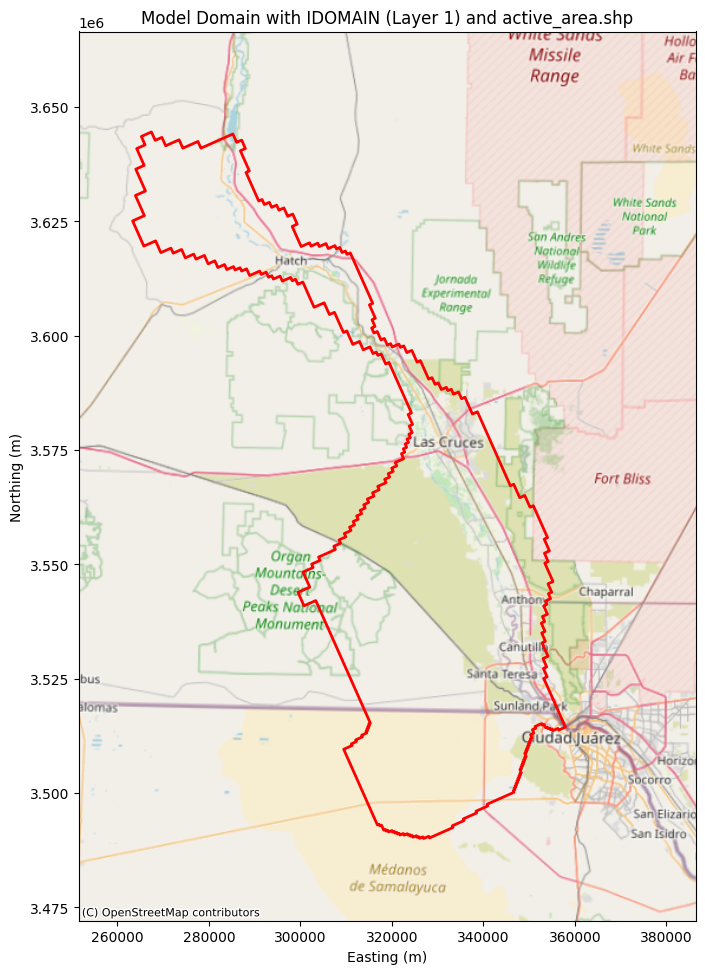

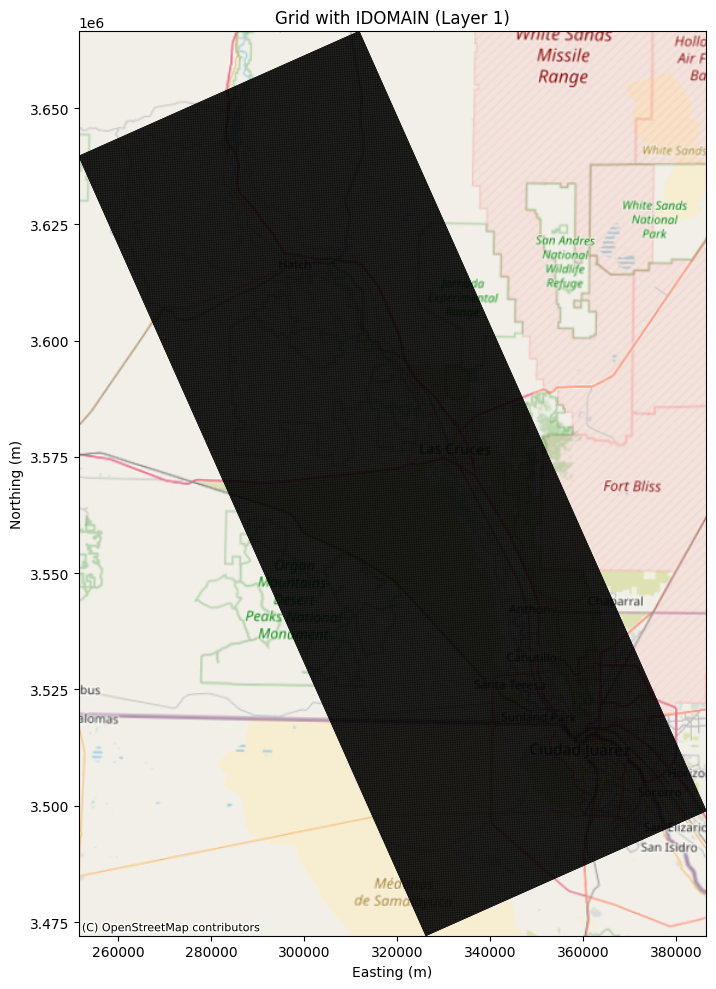

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

# Extract grid coordinates from DIS package
xll = dis.xorigin.get_data()  # Lower-left x
yll = dis.yorigin.get_data()  # Lower-left y
angrot = dis.angrot.get_data()  # Rotation angle in degrees
delr = dis.delr.get_data()  # Cell widths (array)
delc = dis.delc.get_data()  # Cell heights (array)
ncol = dis.ncol.get_data()  # Number of columns
nrow = dis.nrow.get_data()  # Number of rows
idomain = dis.idomain.get_data()  # 3D IDOMAIN array

# Compute rotated grid coordinates (edges, not centers, for extent)
x = np.arange(ncol + 1) * delr[0]  # +1 for edges
y = np.arange(nrow + 1) * delc[0]  # +1 for edges
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))
Y_rot = yll + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))

# Load active area shapefile (assuming gdf is gdf_active from earlier)
gdf = gpd.read_file('./shps/active_area.shp')
if gdf.crs != model_crs:
    gdf = gdf.to_crs(model_crs)

# 1. Overall model domain with IDOMAIN and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
# Use IDOMAIN for layer 0 (Python index 0, MODFLOW layer 1)
ax.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], 
          cmap='binary', alpha=0.5)
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Model Domain with IDOMAIN (Layer 1) and active_area.shp')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()

# 2. Grid outline with IDOMAIN
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.colors.ListedColormap(['white', 'lightgrey'])
bounds = [0, 1, 2]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], 
          cmap=cmap, norm=norm, alpha=0.8, interpolation='nearest')
gdf.plot(ax=ax, edgecolor='lightgrey', facecolor='none', linewidth=2, alpha=0.5)

# Plot grid lines using edge coordinates
for i in range(nrow + 1):  # +1 for edges
    ax.plot(X_rot[i, :], Y_rot[i, :], 'k-', lw=0.5)
for j in range(ncol + 1):  # +1 for edges
    ax.plot(X_rot[:, j], Y_rot[:, j], 'k-', lw=0.5)

cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Grid with IDOMAIN (Layer 1)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()

botm shape: (9, 912, 328)
top shape: (912, 328)
x_rot shape: (912, 328)
y_rot shape: (912, 328)
Row 538, Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Row 538, Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 538, Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 538, Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 538, Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 538, Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 538, Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 538, Layer top bsmt: contains exact -30479.6952=False, close to -30479.6952=False
Row 538, Layer bsmt_botm: contains exact -30479.6952=False, close to -30479.6952=False
Row 538, Top: contains exact -30479.6952=False, close to -30479.6952=False
inactive cells in row 538: [('top rc2', 328), ('top usf1', 328

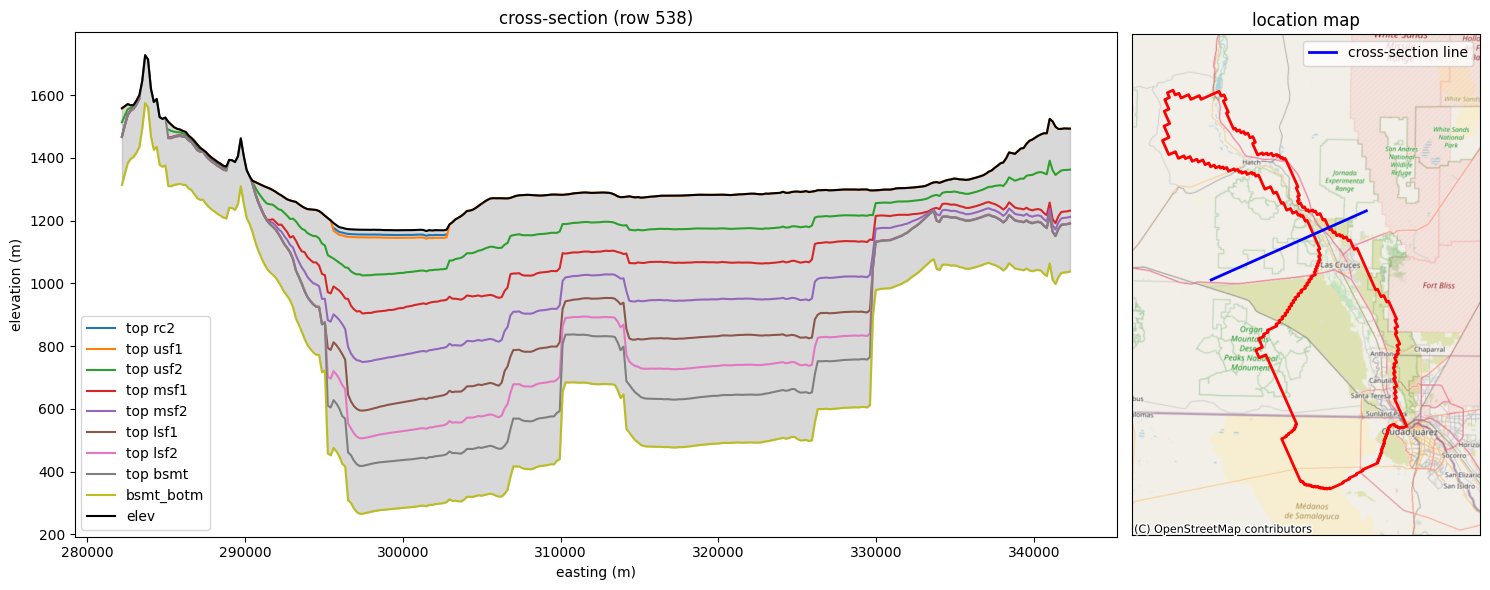

Row 741, Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Row 741, Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 741, Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 741, Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 741, Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 741, Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 741, Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 741, Layer top bsmt: contains exact -30479.6952=False, close to -30479.6952=False
Row 741, Layer bsmt_botm: contains exact -30479.6952=False, close to -30479.6952=False
Row 741, Top: contains exact -30479.6952=False, close to -30479.6952=False
inactive cells in row 741: [('top rc2', 328), ('top usf1', 236), ('top usf2', 236), ('top msf1', 328), ('top msf2', 328), ('top lsf1', 328), ('top lsf2', 328)

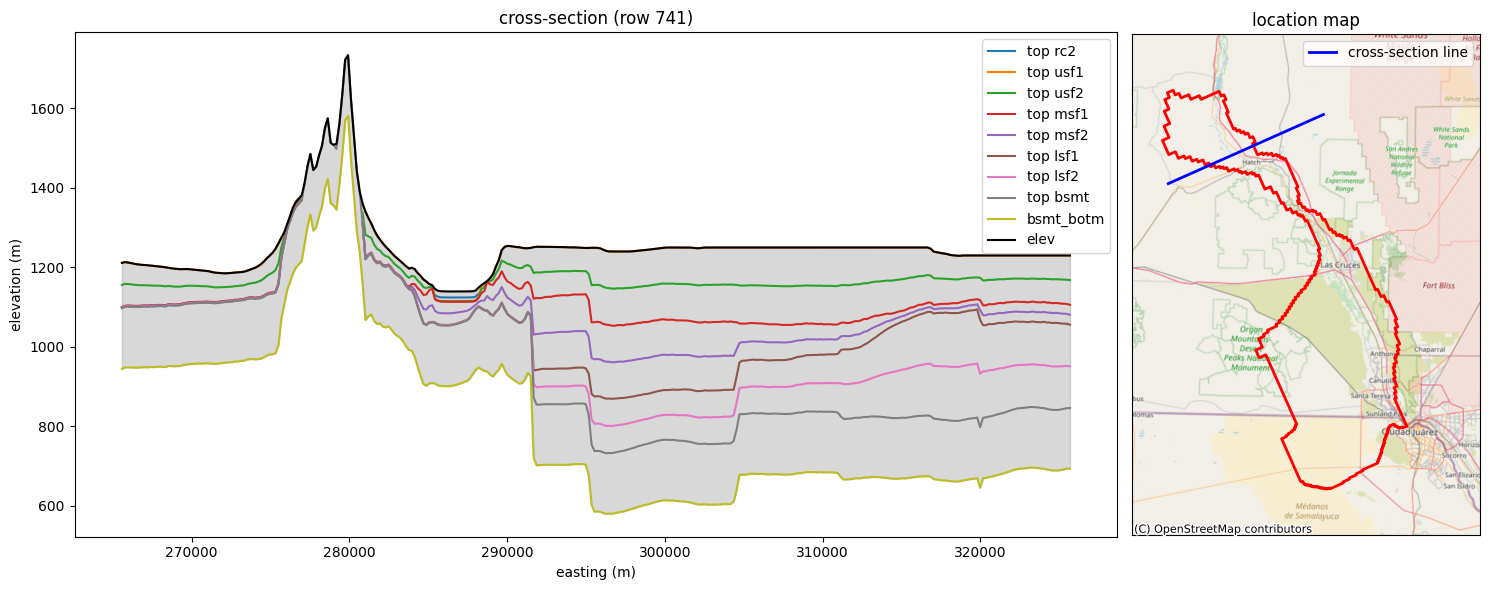

Row 103, Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Row 103, Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 103, Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 103, Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 103, Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 103, Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Row 103, Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Row 103, Layer top bsmt: contains exact -30479.6952=False, close to -30479.6952=False
Row 103, Layer bsmt_botm: contains exact -30479.6952=False, close to -30479.6952=False
Row 103, Top: contains exact -30479.6952=False, close to -30479.6952=False
inactive cells in row 103: [('top rc2', 328), ('top usf1', 254), ('top usf2', 254), ('top msf1', 327), ('top msf2', 327), ('top lsf1', 328), ('top lsf2', 328)

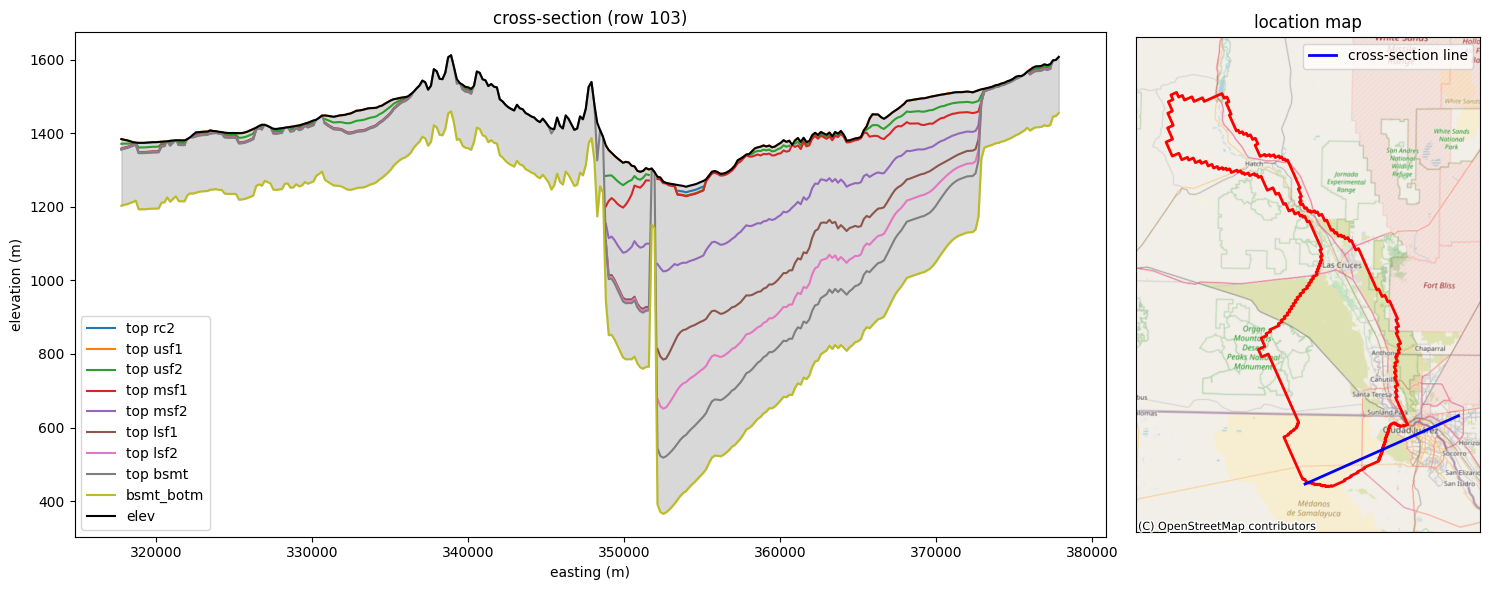

Col 75, Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer top bsmt: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Layer bsmt_botm: contains exact -30479.6952=False, close to -30479.6952=True
Col 75, Top: contains exact -30479.6952=False, close to -30479.6952=False
inactive cells in column 75: [('top rc2', 912), ('top usf1', 770), ('top usf2', 770), ('top msf1', 912), ('top msf2', 912), ('top lsf1', 912), ('top lsf2', 912), ('top bs

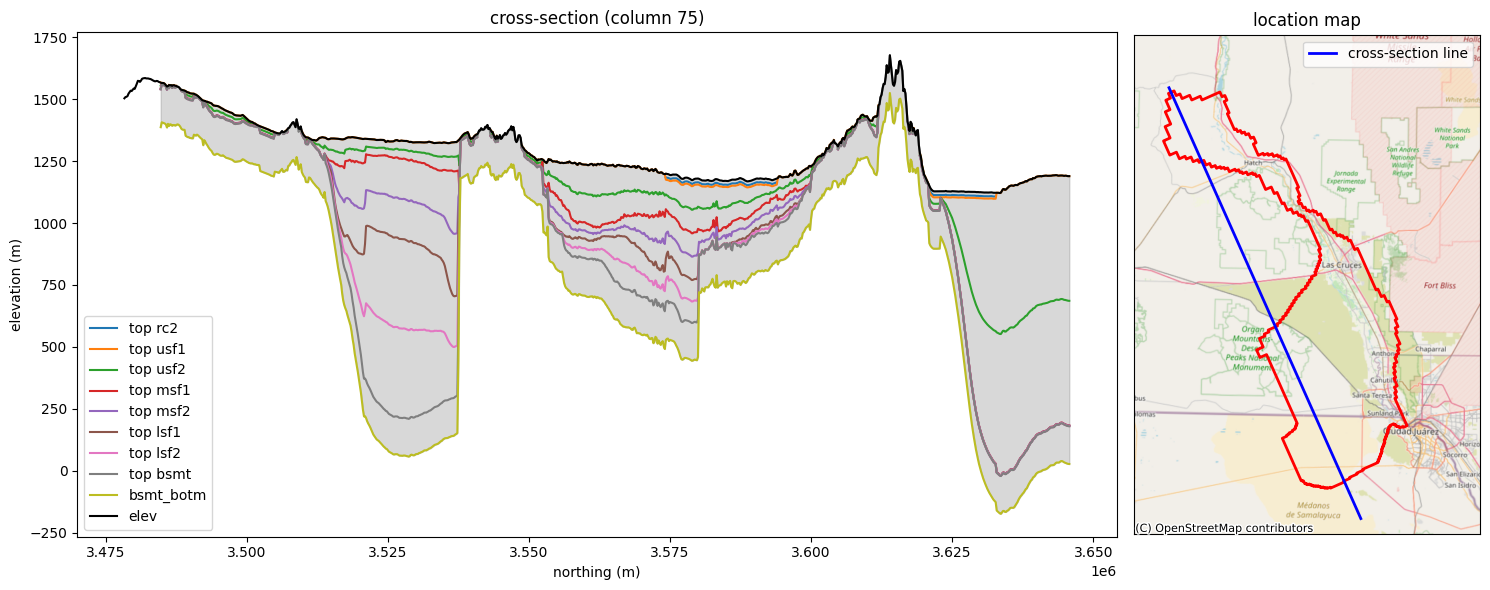

In [26]:
# cross-sections for rows 538, 741, 103, and column 75
rows = [538, 741, 103]
col = 75

layer_names = ["top rc2", "top usf1", "top usf2", 
               "top msf1", "top msf2", "top lsf1", "top lsf2", 
               "top bsmt", "bsmt_botm"]

print("botm shape:", botm.shape)
print("top shape:", top.shape)
print("x_rot shape:", X_rot.shape)
print("y_rot shape:", Y_rot.shape)

# no-data sentinel in meters (approx -99999 feet * 0.3048)
no_data_sentinel = -30479.6952
tolerance = 1.0  # tolerance in meters to catch floating-point variations

# debug function to check for sentinel values
def check_sentinel(data, sentinel, label):
    close_to_sentinel = np.any(np.abs(data - sentinel) < tolerance)
    exact_sentinel = np.any(data == sentinel)
    print(f"{label}: contains exact {sentinel}={exact_sentinel}, close to {sentinel}={close_to_sentinel}")

for row in rows:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

    x_trimmed = X_rot[row, :ncol]
    for lay, name in zip(range(nlay), layer_names):
        bot = botm[lay, row, :]
        # debug: check values in this layer
        check_sentinel(bot, no_data_sentinel, f"Row {row}, Layer {name}")
        # replace values close to sentinel with nan
        bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
        ax1.plot(x_trimmed, bot_plot, label=name)

    top_data = top[row, :]
    check_sentinel(top_data, no_data_sentinel, f"Row {row}, Top")
    top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
    ax1.plot(x_trimmed, top_plot, 'k-', label='elev')

    inactive_cells = [(name, (idomain[lay, row, :] == 0).sum()) for lay, name in enumerate(layer_names)]
    print(f"inactive cells in row {row}: {inactive_cells}")

    botm_base = np.where(np.abs(botm[-1, row, :] - no_data_sentinel) < tolerance, np.nan, botm[-1, row, :])
    top_fill = np.where(np.abs(top[row, :] - no_data_sentinel) < tolerance, np.nan, top[row, :])
    valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
    ax1.fill_between(x_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

    ax1.set_title(f'cross-section (row {row})')
    ax1.set_xlabel('easting (m)')
    ax1.set_ylabel('elevation (m)')
    ax1.legend()

    ax2.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap='binary', alpha=0.5)
    gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
    cx.add_basemap(ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
    ax2.plot(X_rot[row, :], Y_rot[row, :], 'b-', lw=2, label='cross-section line')
    ax2.set_title('location map')
    ax2.legend()
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.tight_layout()
    plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

y_trimmed = Y_rot[:nrow, col]
for lay, name in zip(range(nlay), layer_names):
    bot = botm[lay, :, col]
    check_sentinel(bot, no_data_sentinel, f"Col {col}, Layer {name}")
    bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
    ax1.plot(y_trimmed, bot_plot, label=name)

top_data = top[:, col]
check_sentinel(top_data, no_data_sentinel, f"Col {col}, Top")
top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
ax1.plot(y_trimmed, top_plot, 'k-', label='elev')

inactive_cells_col = [(name, (idomain[lay, :, col] == 0).sum()) for lay, name in enumerate(layer_names)]
print(f"inactive cells in column {col}: {inactive_cells_col}")

botm_base = np.where(np.abs(botm[-1, :, col] - no_data_sentinel) < tolerance, np.nan, botm[-1, :, col])
top_fill = np.where(np.abs(top[:, col] - no_data_sentinel) < tolerance, np.nan, top[:, col])
valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
ax1.fill_between(y_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

ax1.set_title(f'cross-section (column {col})')
ax1.set_xlabel('northing (m)')
ax1.set_ylabel('elevation (m)')
ax1.legend()

ax2.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap='binary', alpha=0.5)
gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax=ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax2.plot(X_rot[:, col], Y_rot[:, col], 'b-', lw=2, label='cross-section line')
ax2.set_title('location map')
ax2.legend()
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()